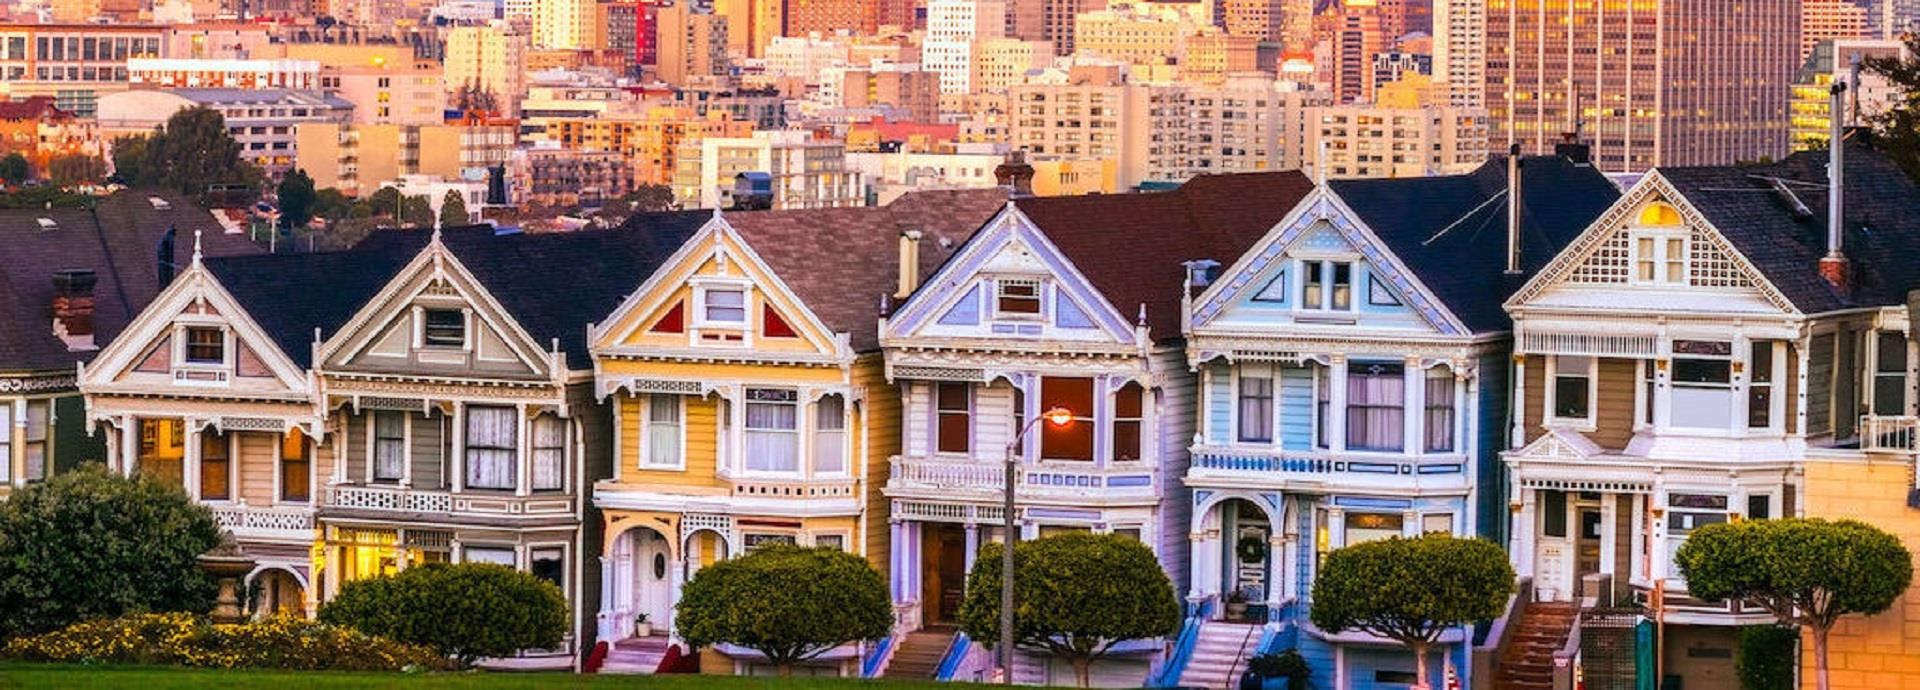

# Zillow Times Series Analysis 
Author: Jennifer Ha
***

## Overview 
This project analyzes New York City Airbnb listings data for the last 12 months (August 2020 - July 2021), which includes detailed information about the hosts and the listings. For the purpose of this project, the Airbnb marketing team would like to know which listings are valuable enough to be selected for their NYC promotion page in the coming winter. With the strong vaccination rate and eased Covid-19 regulation in the city, the team expects that more visitors would be looking for a place to stay in NYC moving forward. Since they cannot go over and compare each listing one by one, the team is looking for a prediction model that they can rely on to carefully select valuable listings that they can promote. They further anticipate to rely on the selected model from this analysis for their future promotions as well.

To help the Airbnb marketing team with accurately selecting the valuable listings in NYC, I'll be comparing classification models and further optimize the best performing model.

## Business Problem
The goal of this analysis is to predict whether a listing is valuable or not. The Airbnb marketing team has decided to consider top 25% listings as valuable, and have asked to calculate a weighted review scores rating to reward listings with more number of reviews and penalize listings with less number of reviews.

The team should be able to use the best model from this analysis to decide which listings are valuable and should be promoted to people who are searching for a place to stay when they visit New York City. We will focus on accuracy, precision, and ROC-AUC scores to determine which model performs the best. In this problem, accurately identifying a valuable listing is important as we cannot falsely advertise a listing with poor ratings.

## Data

This data represents median monthly housing sales prices for 265 zip codes over the period of April 1996 through April 2018 as reported by Zillow.

Each row represents a unique zip code. Each record contains location info and median housing sales prices for each month.

There are 14,723 rows and 272 variables:

RegionID: Unique index, 58196 through 753844
RegionName: Unique Zip Code, 1001 through 99901
City: City in which the zip code is located
State: State in which the zip code is located
Metro: Metropolitan Area in which the zip code is located
CountyName: County in which the zip code is located
SizeRank: Numerical rank of size of zip code, ranked 1 through 14723
1996-04 through 2018-04: refers to the median housing sales values for April 1996 through April 2018, that is 265 data points of monthly data for each zip code


In [1]:
# Import all libraries & packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import time

import warnings
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')

from math import sqrt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error

/Users/jenniferha/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Import data into a dataframe and preview 
df = pd.read_csv('data/zillow_data.csv')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
#Check for duplicates
df.RegionID.duplicated().sum()

0

In [4]:
# Keep CA state only
df_ca = df.loc[df['State']=='CA'].reset_index()

df_ca.info()
df_ca.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1224 entries, 0 to 1223
Columns: 273 entries, index to 2018-04
dtypes: float64(219), int64(50), object(4)
memory usage: 2.5+ MB


,index,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,9,97564,94109,San Francisco,CA,San Francisco,San Francisco,10,766000.0,771100.0,...,3767700,3763900,3775000,3799700,3793900,3778700,3770800,3763100,3779800,3813500
1,15,96107,90250,Hawthorne,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,16,152500.0,152600.0,...,579300,585700,590900,594700,598500,601300,602800,606100,612400,616200
2,27,97771,94565,Pittsburg,CA,San Francisco,Contra Costa,28,139200.0,138300.0,...,394900,398400,401600,405400,408600,410900,413700,417900,424300,430100
3,30,96027,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,31,340600.0,341700.0,...,1839800,1861100,1888600,1903900,1907500,1922100,1952400,1974500,1975900,1966900
4,64,97711,94501,Alameda,CA,San Francisco,Alameda,65,222400.0,222300.0,...,965100,975000,987800,1000000,1009900,1021000,1032400,1042000,1053000,1059700


We want to look at top 30%
I will sort out the zipcodes with highest SizeRank, since the real estate market is higly growing where the urbanization is high. I will keep zip codes that are at top 15 quantile according to the SizeRank variable.

In [5]:
#first, convert SizeRank variable to numeric data type
df_ca["SizeRank"]=df_ca["SizeRank"].astype(int)

#calculate the 0.30 quantile
sr_30q = df_ca.SizeRank.quantile(q=0.30) 

# select data only in top 30 quantile of SizeRank
df_ca= df_ca[df_ca['SizeRank']<=sr_30q]

In [6]:
# Drop unnecessary columns
df_ca.drop(['index', 'RegionID', 'SizeRank'], axis=1, inplace=True)

In [7]:
# Rename "RegionName" to "Zipcode" 
df_ca = df_ca.rename(columns={'RegionName': 'ZipCode'})

df_ca.head()

,ZipCode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,94109,San Francisco,CA,San Francisco,San Francisco,766000.0,771100.0,776500.0,781900.0,787300.0,...,3767700,3763900,3775000,3799700,3793900,3778700,3770800,3763100,3779800,3813500
1,90250,Hawthorne,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,152500.0,152600.0,152600.0,152600.0,152600.0,...,579300,585700,590900,594700,598500,601300,602800,606100,612400,616200
2,94565,Pittsburg,CA,San Francisco,Contra Costa,139200.0,138300.0,137500.0,136600.0,135600.0,...,394900,398400,401600,405400,408600,410900,413700,417900,424300,430100
3,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,340600.0,341700.0,343000.0,344400.0,346100.0,...,1839800,1861100,1888600,1903900,1907500,1922100,1952400,1974500,1975900,1966900
4,94501,Alameda,CA,San Francisco,Alameda,222400.0,222300.0,222400.0,222600.0,223000.0,...,965100,975000,987800,1000000,1009900,1021000,1032400,1042000,1053000,1059700


Our client mainly wants to focus on CA. let's drop the rest.

In [8]:
#Reshape from wide to long format
#Code from Project 4 Start Notebook
def melt_data(df):
    melted = pd.melt(df, 
                     id_vars=['ZipCode', 'City', 'State', 'Metro', 'CountyName'], 
                     var_name='Date')
    melted['Date'] = pd.to_datetime(melted['Date'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [9]:
melted_df = melt_data(df_ca)
melted_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97084 entries, 0 to 97254
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ZipCode     97084 non-null  int64         
 1   City        97084 non-null  object        
 2   State       97084 non-null  object        
 3   Metro       97084 non-null  object        
 4   CountyName  97084 non-null  object        
 5   Date        97084 non-null  datetime64[ns]
 6   value       97084 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 5.9+ MB


In [10]:
#Convert data type to object for ZipCode column
melted_df['ZipCode'] = melted_df['ZipCode'].astype(str)

# Make sure the data type of the 'Date' column is datetime
melted_df['Date'] = pd.to_datetime(melted_df['Date'], format='%Y/%m')

# Set the 'Date' column as index
melted_df.set_index('Date', inplace=True)

melted_df.info
melted_df.head()

,ZipCode,City,State,Metro,CountyName,value
Date,,,,,,
1996-04-01,94109,San Francisco,CA,San Francisco,San Francisco,766000.0
1996-04-01,90250,Hawthorne,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,152500.0
1996-04-01,94565,Pittsburg,CA,San Francisco,Contra Costa,139200.0
1996-04-01,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,340600.0
1996-04-01,94501,Alameda,CA,San Francisco,Alameda,222400.0


While there was a Housing Bubble and Great Despression
[Great Recession](https://en.wikipedia.org/wiki/Great_Recession)


For this dataset, we will only include data from CA. Because of the housing market crash, any modelling that uses only recent years may be misleading. We will use every value from 1996 to 2018 so we can have the most accurate picture of home values in CA through the years.

## Exploratory Data Analysis (EDA)


On this step we will be creating visualizations to get a better idea of what we are working with and also to understand the trends of the values in our data.
Here we get a good idea of the average home value per County name.

In [11]:
print('Average CA home value' ,round(melted_df['value'].mean()))

Average CA home value 476998


average home value by month and year

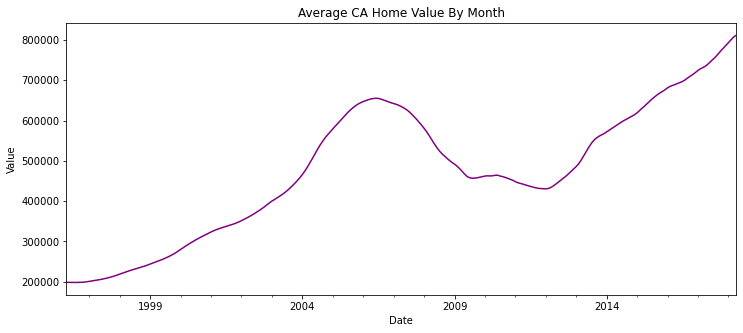

In [12]:
# Resample data by month
month_data = melted_df['value'].resample('MS').mean()
month_data = month_data.fillna(month_data.bfill())
month_data.plot(figsize=(12,5), color='purple')
plt.title('Average CA Home Value By Month')
plt.ylabel('Value')
plt.show()

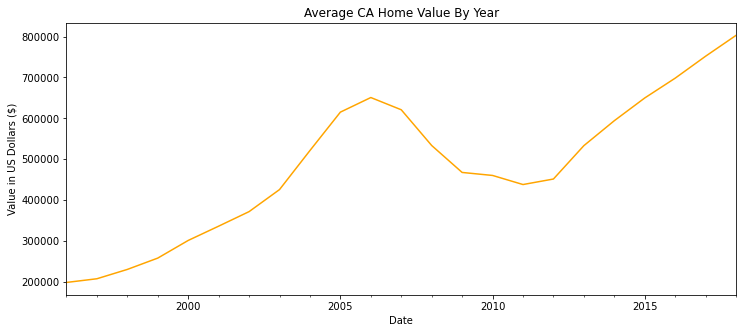

In [13]:
# Resample data by month
yr_data = melted_df['value'].resample('A').mean()
yr_data.plot.line(figsize=(12,5), color='orange')
plt.title('Average CA Home Value By Year')
plt.ylabel('Value in US Dollars ($)')
plt.show()

### Top 10 Metro & County (mean value)

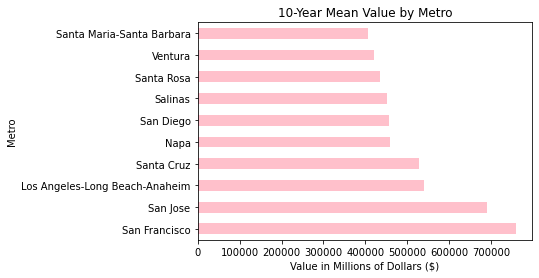

In [14]:
#ajsf;oidjiodj
metro = melted_df.groupby('Metro')
metro = metro.value.mean()
metro = metro.sort_values(ascending=False).head(10)

#ajsf;oidjiodj
metro.plot.barh(color='pink')
plt.title('10-Year Mean Value by Metro')
plt.xlabel('Value in Millions of Dollars ($)')
plt.show()

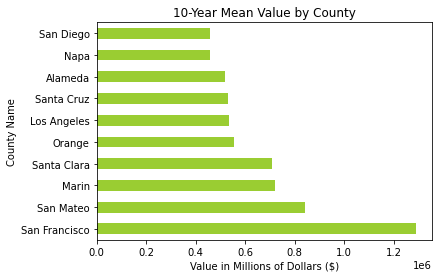

In [15]:
county = melted_df.groupby('CountyName')
county = county.value.mean()
county = county.sort_values(ascending=False).head(10)


county.plot.barh(color='yellowgreen')
plt.title('10-Year Mean Value by County')
plt.xlabel('Value in Millions of Dollars ($)')
plt.ylabel('County Name')
plt.show()

### Top 10 Zipcode ( mean ROI)

For calculating ROI, 
get yr_avg first because we are not measuring how much the home value has increased since July 2009.

In finance, the coefficient of variation allows investors to determine how much volatility, or risk, is assumed in comparison to the amount of return expected from investments. Ideally, if the coefficient of variation formula should result in a lower ratio of the standard deviation to mean return, then the better the risk-return trade-off. Therefore, in these next steps we are going to filter the data some more by calculating the CV value and only selecting values with in the company's risk factor (assume 70 percentile).

In finance, the coefficient of variation allows investors to determine how much volatility, or risk, is assumed in comparison to the amount of return expected from investments.
The lower the ratio of the standard deviation to mean return, the better risk-return trade-off.



In [16]:
#Calculate average home value in the DataFrame
df_ca['yr_avg'] = df_ca.iloc[:,5:].mean(skipna=True, axis=1)


#Calculate historical return on investment
df_ca['ROI'] = (((df_ca['yr_avg'])/df_ca['1996-04'])).round(2)

#Calculate standard deviation of monthly values
df_ca['std'] = df_ca.loc[:,'1996-04':'2018-04'].std(skipna=True, axis=1)

#Calculate historical mean value
df_ca['mean'] = df_ca.loc[:,'1996-04':'2018-04'].mean(skipna=True, axis=1)

#Calculate coefficient of variation
df_ca['CV'] = df_ca['std']/df_ca['mean']

#Show calculated values
df_ca[['ZipCode','yr_avg','std','mean','ROI','CV','CountyName']].head()

,ZipCode,yr_avg,std,mean,ROI,CV,CountyName
0,94109,2.395636e+06,821387.959699,2.395636e+06,3.13,0.342868,San Francisco
1,90250,3.654642e+05,138601.533036,3.654642e+05,2.40,0.379248,Los Angeles
2,94565,2.638743e+05,104006.852657,2.638743e+05,1.90,0.394153,Contra Costa
3,90046,1.041594e+06,431411.591252,1.041594e+06,3.06,0.414184,Los Angeles
4,94501,5.758958e+05,204420.930901,5.758958e+05,2.59,0.354962,Alameda


In [17]:
#find out the top 10 couties with highest ROI (with risk factor)
top10_r = df_ca.groupby('CountyName', group_keys=False).sum()['ROI']
top10_r.sort_values(ascending=False)[:10]

CountyName
Los Angeles       241.97
San Diego         100.58
Orange             77.67
Santa Clara        48.04
Riverside          47.90
Alameda            46.04
San Bernardino     42.84
San Francisco      38.95
Sacramento         30.44
San Mateo          19.79
Name: ROI, dtype: float64

In [18]:
#Get descriptive statistics of coefficients of variance
print(df_ca.CV.describe())

#Get the 10 counties with highest ROIs within the firms risk profile. top 30%
thresh_cv = df_ca.CV.quantile(.3)
print(f'\nCV upper threshold: {thresh_cv}')
top10_nr = df_ca[df_ca['CV']<=thresh_cv].sort_values('ROI', axis=0, ascending=False)

#find out the top 10 couties with highest ROI (without risk factor)
county_grouped = top10_nr.groupby('CountyName').sum()['ROI']
county_grouped.sort_values(ascending=False)[:10]

count    367.000000
mean       0.360297
std        0.047079
min        0.243879
25%        0.324589
50%        0.355550
75%        0.391048
max        0.553350
Name: CV, dtype: float64

CV upper threshold: 0.33036055714049256


CountyName
San Diego      45.34
Orange         33.22
Sacramento     16.85
Riverside      15.10
Ventura        13.25
Santa Clara    11.50
Alameda        11.50
Los Angeles    11.43
Sonoma          8.60
Tulare          6.44
Name: ROI, dtype: float64

In [19]:
top10_county = list(county_grouped.sort_values(ascending=False)[:10].index)
top10_county

['San Diego',
 'Orange',
 'Sacramento',
 'Riverside',
 'Ventura',
 'Santa Clara',
 'Alameda',
 'Los Angeles',
 'Sonoma',
 'Tulare']

In [20]:
#Keep top 10 counties only
df_top10 = top10_nr.loc[top10_nr['CountyName'].isin(top10_county)]

In [21]:
#Check how many zip code are in each county
df_top10['CountyName'].value_counts()

San Diego      20
Orange         14
Sacramento      9
Riverside       8
Ventura         6
Santa Clara     5
Los Angeles     5
Alameda         5
Tulare          4
Sonoma          4
Name: CountyName, dtype: int64

In [22]:
# Highest ROI in each county
df_top10.groupby('CountyName').max()['ROI']

CountyName
Alameda        2.43
Los Angeles    2.39
Orange         2.47
Riverside      2.03
Sacramento     1.97
San Diego      2.68
Santa Clara    2.48
Sonoma         2.30
Tulare         1.76
Ventura        2.37
Name: ROI, dtype: float64

In [23]:
#Get city and state names for each zip code
ziplist = []
roi_top10 = {}

for i in top10_county:
    City = df_top10[df_top10['CountyName']==i].City.values[0]
    Metro = df_top10[df_top10['CountyName']==i].Metro.values[0]
    ZipCode = df_top10[df_top10['CountyName']==i].ZipCode.values[0]
    ROI = (df_top10[df_top10['CountyName']==i].max()['ROI'])
    
    ziplist.append(ZipCode)
    roi_top10[i] = ROI
    print(f'County: {i}, ROI: {ROI} \nCity: {City}, Zipcode: {ZipCode}, Metro: {Metro}\n')

County: San Diego, ROI: 2.68 
City: San Diego, Zipcode: 92103, Metro: San Diego

County: Orange, ROI: 2.47 
City: Rancho Santa Margarita, Zipcode: 92688, Metro: Los Angeles-Long Beach-Anaheim

County: Sacramento, ROI: 1.97 
City: Folsom, Zipcode: 95630, Metro: Sacramento

County: Riverside, ROI: 2.03 
City: Temecula, Zipcode: 92592, Metro: Riverside

County: Ventura, ROI: 2.37 
City: Ventura, Zipcode: 93003, Metro: Ventura

County: Santa Clara, ROI: 2.48 
City: San Jose, Zipcode: 95126, Metro: San Jose

County: Alameda, ROI: 2.43 
City: Oakland, Zipcode: 94611, Metro: San Francisco

County: Los Angeles, ROI: 2.39 
City: Los Angeles, Zipcode: 90731, Metro: Los Angeles-Long Beach-Anaheim

County: Sonoma, ROI: 2.3 
City: Sonoma, Zipcode: 95476, Metro: Santa Rosa

County: Tulare, ROI: 1.76 
City: Visalia, Zipcode: 93291, Metro: Visalia



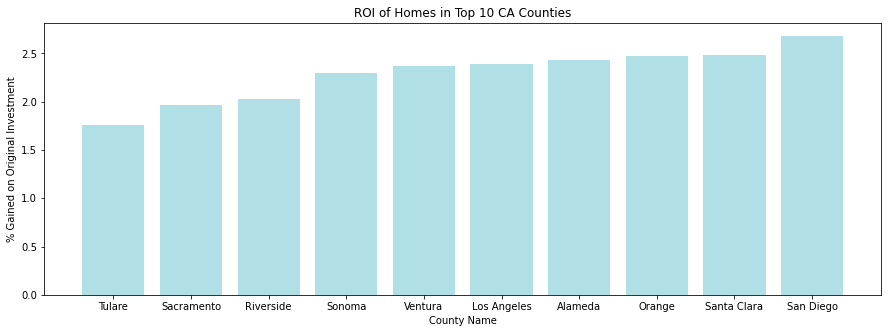

In [24]:
x = dict(sorted(roi_top10.items(), key=lambda item: item[1])).keys()
y = dict(sorted(roi_top10.items(), key=lambda item: item[1])).values()


plt.figure(figsize=(15,5))
plt.bar(x, y, color='powderblue')
plt.title('ROI of Homes in Top 10 CA Counties')
plt.xlabel('County Name')
plt.ylabel('% Gained on Original Investment')
plt.show()

The home sale values have turned up to show that our 10 counties have had an ROI gain of at least 150% of their original value from 1996. With Placer, Orange county, San Luis Obispo and San Diego making it to above 250%.

In [25]:
#save data on each of the 10 zip codes 
df_zip92103 = melted_df[melted_df['ZipCode']=='92103']
df_zip92688 = melted_df[melted_df['ZipCode']=='92688']
df_zip95630 = melted_df[melted_df['ZipCode']=='95630']
df_zip92592 = melted_df[melted_df['ZipCode']=='92592']
df_zip93003 = melted_df[melted_df['ZipCode']=='93003']
df_zip95126 = melted_df[melted_df['ZipCode']=='95126']
df_zip94611 = melted_df[melted_df['ZipCode']=='94611']
df_zip90731 = melted_df[melted_df['ZipCode']=='90731']
df_zip95476 = melted_df[melted_df['ZipCode']=='95476']
df_zip93291 = melted_df[melted_df['ZipCode']=='93291']


In [26]:
#Create a dataframe for the top10 zipcodes
master_zip = pd.DataFrame()
master_zip = master_zip.append(df_zip92103)
master_zip = master_zip.append(df_zip92688)
master_zip = master_zip.append(df_zip95630)
master_zip = master_zip.append(df_zip92592)
master_zip = master_zip.append(df_zip93003)
master_zip = master_zip.append(df_zip95126)
master_zip = master_zip.append(df_zip94611)
master_zip = master_zip.append(df_zip90731)
master_zip = master_zip.append(df_zip95476)
master_zip = master_zip.append(df_zip93291)
master_zip.info()
master_zip.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2650 entries, 1996-04-01 to 2018-04-01
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ZipCode     2650 non-null   object 
 1   City        2650 non-null   object 
 2   State       2650 non-null   object 
 3   Metro       2650 non-null   object 
 4   CountyName  2650 non-null   object 
 5   value       2650 non-null   float64
dtypes: float64(1), object(5)
memory usage: 144.9+ KB


,ZipCode,City,State,Metro,CountyName,value
Date,,,,,,
1996-04-01,92103,San Diego,CA,San Diego,San Diego,242700.0
1996-05-01,92103,San Diego,CA,San Diego,San Diego,242600.0
1996-06-01,92103,San Diego,CA,San Diego,San Diego,242500.0
1996-07-01,92103,San Diego,CA,San Diego,San Diego,242400.0
1996-08-01,92103,San Diego,CA,San Diego,San Diego,242500.0


In [27]:
zip_ts = []
for zc in master_zip.ZipCode.unique():
    #Create separate dataframes for each zipcode with a monthly frequency.
    top10_df = master_zip[master_zip['ZipCode']==zc].asfreq('MS')
    zip_ts.append(top10_df)

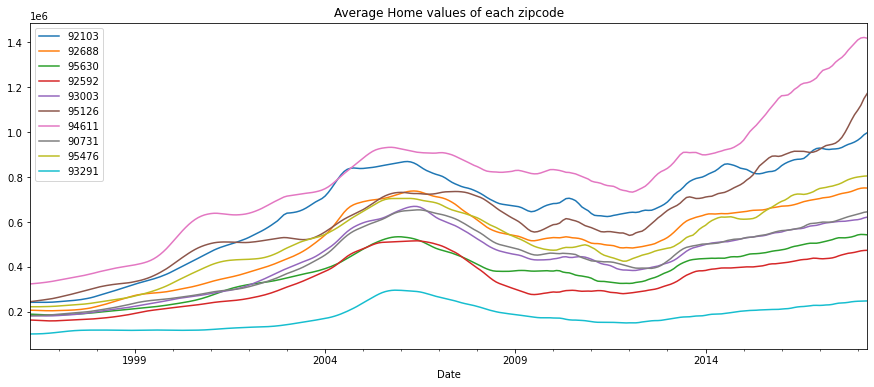

In [28]:
for i in range(10):
    zip_ts[i].value.plot(label=zip_ts[i].ZipCode[0],figsize=(15,6))
    plt.title('Average Home values of each zipcode')
    plt.legend()

## Improving Stationarity

While the trend in most zipcodes seem to be stationary, there are still evident fluctuation across all with 94920 showing the most.

In [ ]:
#Calculate monthly returns in new column 'ret' for each zipcode.
for zc in range(len(zip_ts)):
    zip_ts[zc]['ret']=np.nan*len(zip_ts[zc])
    for i in range(len(zip_ts[zc])-1):
        zip_ts[zc]['ret'][i+1]= (zip_ts[zc].value.iloc[i+1] / zip_ts[zc].value.iloc[i]) - 1

In [ ]:
for i in range(10):
    results = adfuller(zip_ts[i].ret.dropna())
    print(f'ADFuller test p-value for zipcode: {zip_ts[i].ZipCode[0]}')
    print('p-value:',results[1])
    if results[1]>0.05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
    else:
        print('Reject the null hypothesis. Data is stationary.\n')

우리가 예상했던 것처럼 거의 다 not stationary

#### P-value Check - Differencing Values for Each Zipcode

In [ ]:
master_zip2 = pd.DataFrame()

df_zip1['difference'] = df_zip1.value.diff()
df_zip1['ROI'] = df_zip1['difference']/df_zip1['value']
df_zip1 = df_zip1.dropna()
master_zip2 = master_zip2.append(df_zip1)


df_zip2['difference'] = df_zip2.value.diff()
df_zip2['ROI'] = df_zip2['difference']/df_zip2['value']
df_zip2 = df_zip2.dropna()
master_zip2 = master_zip2.append(df_zip2)

df_zip3['difference'] = df_zip3.value.diff()
df_zip3['ROI'] = df_zip3['difference']/df_zip3['value']
df_zip3 = df_zip3.dropna()
master_zip2 = master_zip2.append(df_zip3)
                        
df_zip4['difference'] = df_zip4.value.diff()
df_zip4['ROI'] = df_zip4['difference']/df_zip4['value']
df_zip4 = df_zip4.dropna()
master_zip2 = master_zip2.append(df_zip4)
                        
df_zip5['difference'] = df_zip5.value.diff()
df_zip5['ROI'] = df_zip5['difference']/df_zip5['value']
df_zip5 = df_zip5.dropna()
master_zip2 = master_zip2.append(df_zip5)
                        
df_zip6['difference'] = df_zip6.value.diff()
df_zip6['ROI'] = df_zip6['difference']/df_zip6['value']
df_zip6 = df_zip6.dropna()
master_zip2 = master_zip2.append(df_zip6)
                        
df_zip7['difference'] = df_zip7.value.diff()
df_zip7['ROI'] = df_zip7['difference']/df_zip7['value']
df_zip7 = df_zip7.dropna()
master_zip2 = master_zip2.append(df_zip7)
                        
df_zip8['difference'] = df_zip8.value.diff()
df_zip8['ROI'] = df_zip8['difference']/df_zip8['value']
df_zip8 = df_zip8.dropna()
master_zip2 = master_zip2.append(df_zip8)
                        
df_zip9['difference'] = df_zip9.value.diff()
df_zip9['ROI'] = df_zip9['difference']/df_zip9['value']
df_zip9 = df_zip9.dropna()
master_zip2 = master_zip2.append(df_zip9)
                        
df_zip10['difference'] = df_zip10.value.diff()
df_zip10['ROI'] = df_zip10['difference']/df_zip10['value']
df_zip10 = df_zip10.dropna()
master_zip2 = master_zip2.append(df_zip10)

In [ ]:
df_top10 = pd.concat([df_zip1,df_zip2,df_zip3,df_zip4,df_zip5,df_zip6,df_zip7,df_zip8,df_zip9,df_zip10])

#Convert data type to object for ZipCode column
df_top10['ZipCode'] = df_top10['ZipCode'].astype(str)
df_top10.info()
df_top10.head()

In [ ]:
zip_ts2 = []
for zc in master_zip2.ZipCode.unique():
    #Create separate dataframes for each zipcode with a monthly frequency.
    top10_df2 = master_zip2[master_zip2['ZipCode']==zc].asfreq('MS')
    zip_ts2.append(top10_df2)

In [ ]:
for i in range(10):
    zip_ts2[i].ROI.plot(label=zip_ts2[i].ZipCode[0],figsize=(15,6))
    plt.title('Average Home values of each zipcode')
    plt.legend(loc='upper left')

In [ ]:
for i in range(10):
    #Perform adfuller test and drop NaN values created when calculating monthly returns.
    results = adfuller(zip_ts2[i].ROI.diff().dropna()) #differencing by 12 month for stationarity
    print(f'ADFuller test p-value for zipcode: {zip_ts2[i].ZipCode[0]}')
    print('p-value:',results[1])
    if results[1]>0.05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
    else:
        print('Reject the null hypothesis. Data is stationary.\n')

In [ ]:
def plot_roi(df):
    axes = df.reset_index().pivot(index='Date',
    columns = 'ZipCode',
    values = 'ROI').plot(
        subplots=True,
        figsize=(10,40)); 
    zips = df.ZipCode.unique()
    for idx in range(len(zips)): 
        axes[idx].legend(fontsize=15, loc='upper left')

In [ ]:
plot_roi(df_top10)

## Stationarity Test

In [29]:
# The top 10 list we will be analyzing 
ziplist = ['92103', '92688', '95630', '92592', '93003', '95126', '94611','90731', '95476', '93291']

In [30]:
#create a dictionary for each zipcode
ts = {}
for zc in ziplist:
    temp_df = melted_df.groupby('ZipCode').get_group(zc).sort_index()['value']
    ts[zc] = temp_df

In [31]:
ts_df = pd.DataFrame(ts)
ts_df.head()

,92103,92688,95630,92592,93003,95126,94611,90731,95476,93291
Date,,,,,,,,,,
1996-04-01,242700.0,207600.0,190000.0,163900.0,182900.0,245400.0,324400.0,183100.0,222900.0,101800.0
1996-05-01,242600.0,207100.0,189300.0,163200.0,182700.0,247200.0,325600.0,183500.0,222800.0,101900.0
1996-06-01,242500.0,206500.0,188500.0,162400.0,182400.0,249000.0,326900.0,184000.0,222900.0,102200.0
1996-07-01,242400.0,206000.0,187800.0,161700.0,182200.0,251000.0,328400.0,184500.0,223000.0,102600.0
1996-08-01,242500.0,205600.0,187300.0,161000.0,182100.0,252900.0,330000.0,185100.0,223200.0,103200.0


In [32]:
ts_92103 = ts_df[ziplist[0]].copy()
ts_92688 = ts_df[ziplist[1]].copy()
ts_95630 = ts_df[ziplist[2]].copy()
ts_92592 = ts_df[ziplist[3]].copy()
ts_93003 = ts_df[ziplist[4]].copy()
ts_95126 = ts_df[ziplist[5]].copy()
ts_94611 = ts_df[ziplist[6]].copy()
ts_90731 = ts_df[ziplist[7]].copy()
ts_95476 = ts_df[ziplist[8]].copy()
ts_93291 = ts_df[ziplist[9]].copy()

In [ ]:
def stationarity_check(TS):
    """Calculate rolling statistics and plot against original time series, perform and output Dickey Fuller test."""
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=24, center=False).mean()
    roll_std = TS.rolling(window=24, center=False).std()
        
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS)
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    plt.plot(TS, color='blue',label='Original')
    plt.plot(roll_mean.dropna(), color='red', label='Rolling Mean')
    plt.plot(roll_std.dropna(), color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.savefig('Images/rolling.png')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

In [ ]:
stationarity_check(ts_92103)

In [ ]:
stationarity_check(ts_92688)

In [ ]:
stationarity_check(ts_95630)

In [ ]:
stationarity_check(ts_92592)

In [ ]:
stationarity_check(ts_93003)

In [ ]:
stationarity_check(ts_95126)

In [ ]:
stationarity_check(ts_94611)

In [ ]:
stationarity_check(ts_90731)

In [ ]:
stationarity_check(ts_95476)

In [ ]:
stationarity_check(ts_93291)

In [65]:
all_ts = [ts_92103,ts_92688,ts_95630,ts_92592,ts_93003,ts_95126,ts_94611,ts_90731,ts_95476,ts_93291]

In [66]:
def test_split(list_of_df, names):
    return_list=[]
    for i, df in enumerate(list_of_df):
        test_nobs=int((len(df))*.20)
        train = df[:-(test_nobs)]
        test = df[-(test_nobs):]
        return_list.extend([train, test])
        print(names[i], ': ', df.shape, 'Train: ', train.shape, 'Test: ', test.shape)
    return return_list

train_92103, train_92688, train_95630, train_92592, train_93003, train_95126, train_94611, train_90731, train_95476, \
train_93291, test_92103, test_92688, test_95630, test_92592, test_93003, test_95126, test_94611,test_90731, test_95476, test_93291 = test_split(all_ts, ziplist)

92103 :  (265,) Train:  (212,) Test:  (53,)
92688 :  (265,) Train:  (212,) Test:  (53,)
95630 :  (265,) Train:  (212,) Test:  (53,)
92592 :  (265,) Train:  (212,) Test:  (53,)
93003 :  (265,) Train:  (212,) Test:  (53,)
95126 :  (265,) Train:  (212,) Test:  (53,)
94611 :  (265,) Train:  (212,) Test:  (53,)
90731 :  (265,) Train:  (212,) Test:  (53,)
95476 :  (265,) Train:  (212,) Test:  (53,)
93291 :  (265,) Train:  (212,) Test:  (53,)


In [67]:
all_train_df = [train_92103, train_92688, train_95630, train_92592, train_93003, train_95126, train_94611,
                train_90731, train_95476,]
all_test_df =  [test_95630, test_92592, test_93003, test_95126, test_94611,test_90731, test_95476, test_93291]

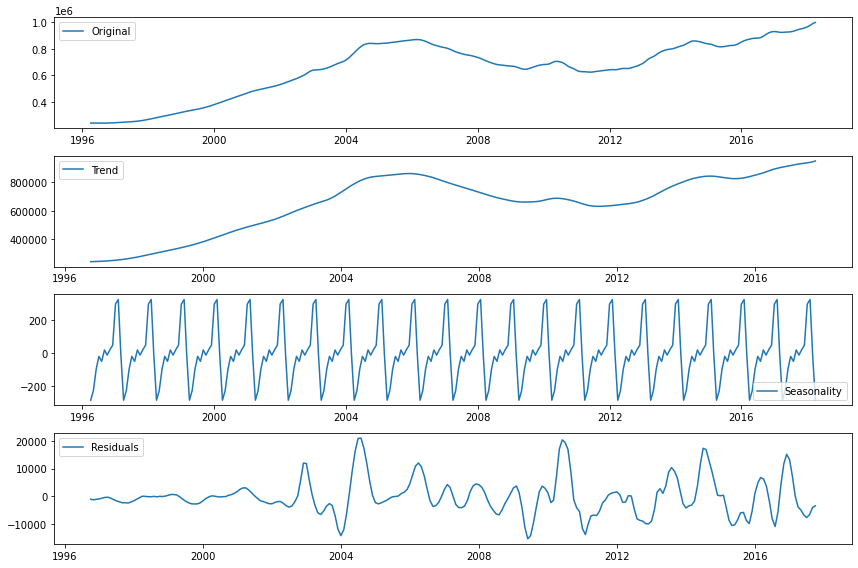

In [35]:
decomposition = seasonal_decompose(ts_92103)

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(ts_92103, label='Original')#np.log(ts)
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.savefig('Images/decomposition.png')
plt.tight_layout()


## Preprocessing

### Train-Test Split

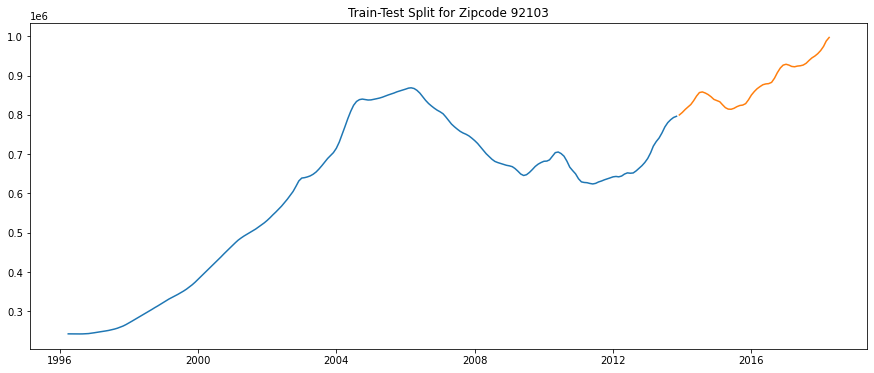

In [33]:
train_size = 0.8
split_idx = round(len(ts_92103)* train_size)
split_idx

## Split
train = ts_92103.iloc[:split_idx]
test = ts_92103.iloc[split_idx:]

## Visualize split
# Looking at big city dataset as an example
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(train)
ax.plot(test)
ax.set_title('Train-Test Split for Zipcode 92103');

## Model 1: Random Walk Model

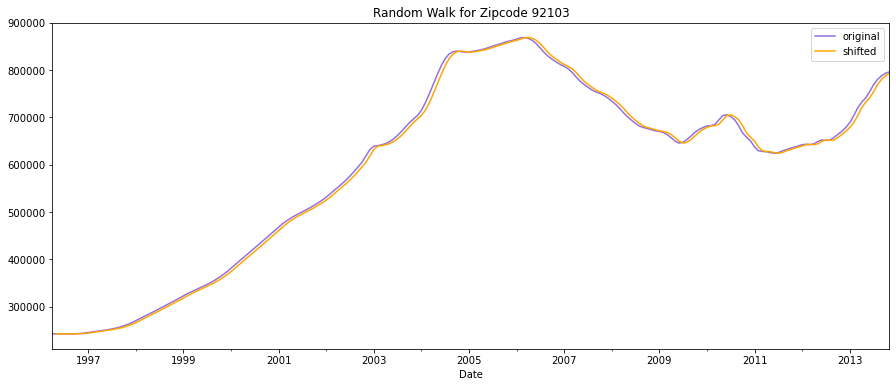

In [51]:
train = ts_92103.iloc[:split_idx]
random_walk = train.shift(1)

fig, ax = plt.subplots(figsize=(15,6))

train[0:270].plot(ax=ax, c='mediumpurple', label='original')
random_walk[0:270].plot(ax=ax, c='orange', label='shifted')
ax.set_title('Random Walk for Zipcode 92103')
ax.legend();

In [56]:
# Calculate Root Mean Squared Error for above data 
residuals = random_walk - train
rmse = mean_squared_error(train[1:], random_walk.dropna(),squared=False)
rmse # use as benchmark for our modeling process

6820.129809330153

## Model 2: ARIMA Model

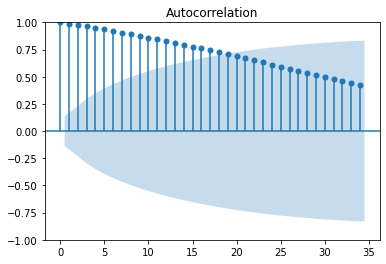

In [57]:
plot_acf(train,lags=34);

In [58]:
import matplotlib as mpl


def plot_acf_pacf(ts, figsize=(10,8),lags=24):
    
    fig,ax = plt.subplots(nrows=3,
                          figsize=figsize)
    
    ## Plot ts
    ts.plot(ax=ax[0])
    
    ## Plot acf, pavf
    plot_acf(ts,ax=ax[1],lags=lags)
    plot_pacf(ts, ax=ax[2],lags=lags) 
    fig.tight_layout()
    
    fig.suptitle(f"Zipcode: {ts.name}",y=1.1,fontsize=20)
    
    for a in ax[1:]:
        a.xaxis.set_major_locator(mpl.ticker.MaxNLocator(min_n_ticks=lags, integer=True))
        a.xaxis.grid()
    return fig,ax

The above autocorrelation shows that there is corrletation between lags up about 20 weeks back. Due to the strong correlation with higher order lags, I will check if first difference makes them any better.

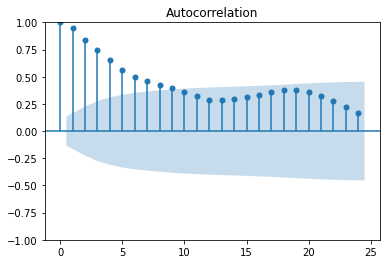

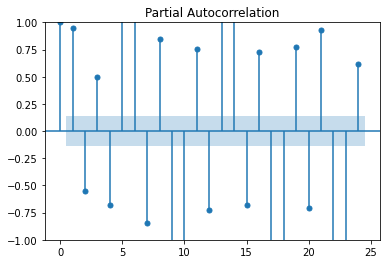

In [59]:
#(0,1,0) model results
plot_acf(train.diff().dropna());
plot_pacf(train.diff().dropna());

ACF plot looks better but still tells us that there is a strong correlation with lag around 10. Also, our PACF shows an extremely different result where all lags are statiscally significant. Our first model did not do so well, and therefore, we will run more iterations below. We will explore auto-arima and SARIMAX but I would like to try hand-manually selecting the parameter values based on the result above. Nothing is guaranteed but I'm hoping to see better results.

## Model 2: ARIMA Model - Handpicking Hyperparameter Values

In [49]:
def rmse_arima(ts, p, d, q):
    model = ARIMA(ts, order =(p,d,q)).fit()
    preds = model.predict(typ='levels')
    rmse = np.sqrt(mean_squared_error(ts, preds))
    print(f'{rmse}')
    return rmse

def aic_arima(ts, p, d, q): 
    model = ARIMA(ts, order = (p,d,q)).fit()
    aic = model.aic
    print(f'{aic}')
    

In [50]:
rmse_arima(train, 1, 2, 1)
aic_arima(train, 1, 2, 1)

/Users/jenniferha/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jenniferha/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jenniferha/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jenniferha/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency infor

21321.342211724736
3860.8164027782664


In [60]:
rmse_arima(train, 2, 1, 1)
aic_arima(train, 2, 1, 1)

/Users/jenniferha/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jenniferha/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jenniferha/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jenniferha/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

17700.28639479617
4275.816820585927


/Users/jenniferha/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [61]:
rmse_arima(train, 3, 1, 2)
aic_arima(train, 3, 1, 2)

/Users/jenniferha/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jenniferha/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jenniferha/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jenniferha/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

17696.716962732582
5370.790123886629


/Users/jenniferha/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [63]:
rmse_arima(train, 5, 1, 5)
aic_arima(train, 5, 1, 5)

/Users/jenniferha/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jenniferha/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jenniferha/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


17461.837106736104


/Users/jenniferha/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jenniferha/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jenniferha/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


6432.720036605555


I imangined that this could be a fun excercise but the results are too disappointing. Not only the RMSE incrased significantly from our Random Walk Model, but AIC value continues to increase when we try to bring down the RMSE. Therefore, we will start running the auto-arima and SARIMAX models below.

## Model 3: AUTO-ARIMA Model

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=3812.107, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=3812.696, Time=0.16 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=3812.716, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=3860.816, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=3814.088, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.375 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1905.054
Date:                Fri, 29 Oct 2021   AIC                           3812.107
Time:                        04:49:29   BIC                           3815.454
Sample:                             0   HQIC                          3813.460
                                - 212                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.395e+06    2.9e+05     15.149      0.000    3.83e+06    4.96e+06
===================================================================================
Ljung-Box (L1) (Q):                  46.00   Jarque-Bera (JB):                49.43
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              69.28   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

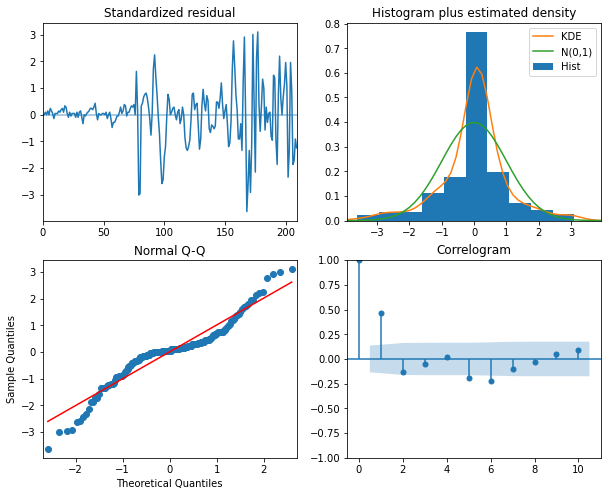

In [75]:
auto_model = auto_arima(train,start_p=0,start_q=0, seasonal=True, trace=True)
display(auto_model.summary())
auto_model.plot_diagnostics(figsize=(10,8));

In [80]:
forecast = auto_model.get_forecast(steps=len(test))

In [83]:
def forecast_to_df(forecast,zipcode):
    test_pred = forecast.conf_int()
    test_pred[zipcode] = forecast.predicted_mean
    test_pred.columns = ['lower','upper','prediction']
    return test_pred

pred_df = forecast_to_df(forecast,ziplist[0])
pred_df.head()

,lower,upper,prediction
2013-12-01,795291.103516,803508.896484,799400.0
2014-01-01,793212.228149,811587.771851,802400.0
2014-02-01,790025.917119,820774.082881,805400.0
2014-03-01,785894.647093,830905.352907,808400.0
2014-04-01,780927.608112,841872.391888,811400.0


In [102]:
def plot_train_test_pred(train,test,pred_df):
    fig,ax = plt.subplots(figsize=(12,7))
    kws = dict(marker='o')
    
    ax.plot(train,label='Train',**kws)
    ax.plot(test,label='Test',**kws)
    ax.plot(pred_df['prediction'],label='prediction',ls='--',**kws)

    ax.fill_between(x=pred_df.index,y1=pred_df['lower'],y2=pred_df['upper'])
    ax.legend(bbox_to_anchor=[1,1])
    fig.tight_layout()
    return fig,ax

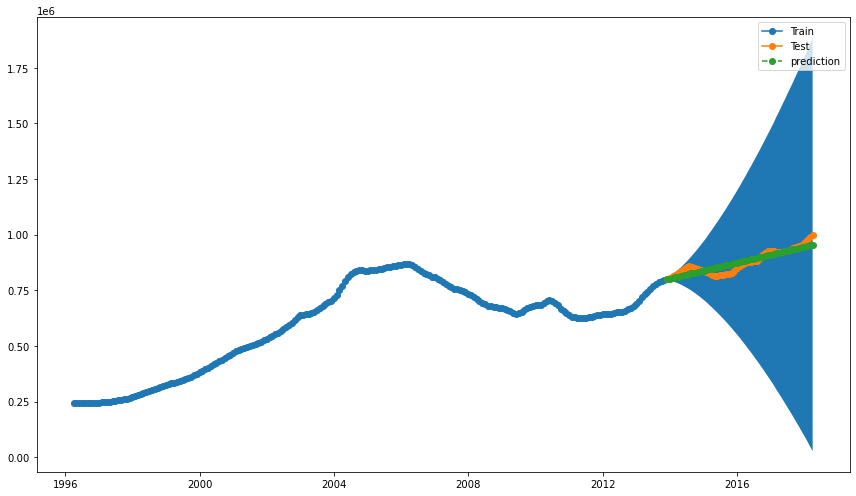

In [103]:
plot_train_test_pred(train,test,pred_df)

plt.show()

This ARIMA model with gridsearch worked pretty well as it was able to predict our test set close.

In [ ]:
pred = model3.get_forecast(steps=12)#start=test.index[0],end=test.index[-1])
pred_df = forecast_to_df(pred,zip_1)
display(plot_train_test_pred(train,test,pred_df));
plt.show()

/Users/jenniferha/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jenniferha/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jenniferha/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


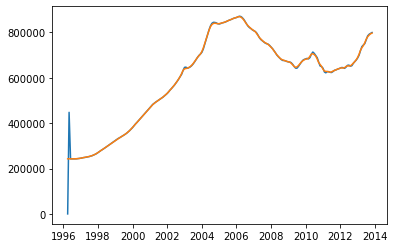

In [77]:
#Plotting training predictions
auto_model = ARIMA(train,order=(0,2,0)).fit()
y_hat_train = auto_model.predict(typ='levels')

fig, ax=plt.subplots()
ax.plot(y_hat_train);
ax.plot(train);

explain how well auto arima worked

## Model 4: SARIMAX Model

In [ ]:
all_dfs = [df_zip1,df_zip2,df_zip3,df_zip4,df_zip5,df_zip6,df_zip7,df_zip8,df_zip9,df_zip10]
names = ['Philadelphia','Indianapolis','Daytona','Columbus','KansasCity','Chattanooga']

In [ ]:
def rmse_arima(ts, p, d, q): 
    model = ARIMA(ts, order =(p,d,q)).fit()
    preds = model.predict(typ='levels')
    rmse = np.sqrt(mean_squared_error(ts, preds))
    return rmse

In [ ]:
rmse_arima(train, 1, 1, 1)

In [ ]:
#Original Miami data
plot_acf(train);

In [ ]:
# selected params
d = 1
p = 1
q = 1

model1 = ARIMA(train, (0,1,0)).fit()

In [ ]:
## Baseline model from eye-balled params
model2 = SARIMAX(train,order=(p,d,q),).fit()
display(model2.summary())
model2.plot_diagnostics(figsize=(10,8));
plt.show()

In [ ]:
train = ts_ca.iloc[:split_idx]
random_walk = train.shift(1)

fig, ax = plt.subplots(figsize=(15,6))

train[0:270].plot(ax=ax, c='mediumpurple', label='original')
random_walk[0:270].plot(ax=ax, c='orange', label='shifted')
ax.set_title('Random Walk for Zipcode 92103')
ax.legend();

In [ ]:
# Calculate Root Mean Squared Error for above data 
residuals = random_walk - train
rmse = mean_squared_error(train[1:], random_walk.dropna(),squared=False)
rmse # use as benchmark for our modeling process

In [ ]:
plt.plot(residuals.index, residuals)
plt.plot(residuals.index, residuals.rolling(30).std())

### Model 2: Auto-ARIMA Model

In [ ]:
mod2 = auto_arima(train,start_p=0,start_q=0)

In [ ]:
mod2.get_params()

In [ ]:
mod2_with_params = auto_arima(train,order=mod2.order,
                     seasonal_order=mod2.seasonal_order).fit()

Recommendation:
1. potentially layering in population data
2. include more recent data